In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math

In [4]:
# Get data for a given ticker
ticker = "AMZN"
df = yf.Ticker(ticker).history("1y")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-31 00:00:00-05:00,168.955994,169.350006,166.558502,166.716995,47830000,0.0,0.0
2022-01-03 00:00:00-05:00,167.550003,170.703506,166.160507,170.404495,63520000,0.0,0.0
2022-01-04 00:00:00-05:00,170.438004,171.399994,166.349503,167.522003,70726000,0.0,0.0
2022-01-05 00:00:00-05:00,166.882996,167.126495,164.356995,164.356995,64302000,0.0,0.0
2022-01-06 00:00:00-05:00,163.450500,164.800003,161.936996,163.253998,51958000,0.0,0.0


In [10]:
N = 50

# calculate rolling mean and std
df["SMA"] = df["Close"].rolling(window = N).mean()
df["Std"] = df["Close"].rolling(window = N).std()

# calculate upper and lower bollinger band
df["Upper"] = df["SMA"] + df["Std"] * 2
df["Lower"] = df["SMA"] - df["Std"] * 2

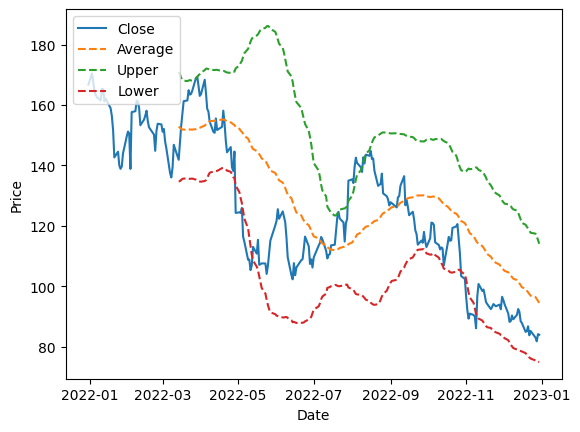

In [9]:
# plot the results
plt.plot(df["Close"], label="Close")
plt.plot(df["SMA"], label = "Average", ls = '--')
plt.plot(df["Upper"], label="Upper", ls = '--')
plt.plot(df["Lower"], label="Lower", ls = '--')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.show()

In [ ]:
trading_fee = 0.05
counter = 0
for t, row in df.iterrows():

    # do nothing for the first N days
    if counter < N:
        df.loc[t, "bollinger_profit"] = 0
        prev_row = row
    else:
        
        # if previous close is above upper band, buy
        if(prev_row["Close"] > prev_row["Upper"]):
            capital_yesturday = prev_row['Capital']
            df.loc[t, "shares_held"] = math.floor(capital_yesturday/row['Close']) 
            df.loc[t, "Capital"] = capital_yesturday - df.loc[t, "shares_held"] * row['Close'] * (1 + trading_fee)
            buy_price = row['Close'] * (1 + trading_fee)

        # if previous close is below lower band and we hold shares, sell
        elif(prev_row["Close"] < prev_row["Lower"] and df["shares_hold"] != 0):
            capital_yesturday = prev_row['Capital']
            df.loc[t, "Capital"] = capital_yesturday + prev_row["shares_held"] * row['Close'] * (1 - trading_fee)
            sell_price = row['Close'] * (1 - trading_fee)
            df.loc[t, "Profit"] = (sell_price - buy_price) * prev_row["shares_held"]
            df.loc[t, "shares_held"] = 0





